# Creating templates for the artefacts and using them to write the artefact correction functions

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne import create_info
from mne.io import RawArray
import pickle
from scipy.signal import firwin, lfilter, find_peaks
from scipy.fftpack import fft
import os
import pandas as pd
import scipy.signal
from scipy.stats import linregress
from BBO_Analysis_Functions import infer_rights, correct_drift
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('Qt5Agg')

In [3]:
# Load the data and do the basic stuff
# File index to extract
EMGpath = "Path to raw EMG data/EMG/" 
# extract all .mat files in the folder
EMGfiles = [f for f in os.listdir(EMGpath) if f.endswith('.mat')]

index = 27

EMGfile = EMGfiles[index]
participant = EMGfile[:-4]
fpath = os.path.join(EMGpath, EMGfile)
data = scipy.io.loadmat(fpath)
keys = list(data.keys())
print(participant)
srate = 2000

processed_path = "Path to processed EMG data/Processed/"
if not os.path.exists(processed_path):
    os.makedirs(processed_path)
    print(f"Folder created: {processed_path}")
else:
    print(f"Folder already exists: {processed_path}")

subject_write_path = os.path.join(processed_path, participant)
if not os.path.exists(subject_write_path):
    os.makedirs(subject_write_path)
    print(f"Folder created: {subject_write_path}")

# Import the csv file with psychopy data
responsepath = "Path to Psychopy data/Psychopy/"
responsefiles = [f for f in os.listdir(responsepath) if f.endswith('.csv') and (f.__contains__(EMGfile[3:-4] + '_' + EMGfile[:3]) and f.startswith(EMGfile[3:-4]+'_') and not f.__contains__('trial'))]
responsefiles.sort()
filename = responsefiles[0]
print(filename)

# try each file to see if it is the correct one
for filename in responsefiles:
    fpath = os.path.join(responsepath, filename)
    responses = pd.read_csv(fpath)
    if 'p_port' not in responses.keys():
        continue
    elif len(responses['p_port']>1) == 102:
        break
    

# Assert that the EEG and the response file match in the participant number
assert int(filename.split('_')[0]) == index+1 == int(participant[3:]), 'EMG and Psychopy files do not match'

fpath = os.path.join(responsepath, filename)
responses = pd.read_csv(fpath)

# Store behavioural data
age = responses['O_Age.response'].dropna().values[0]
gender = responses['slider_gender.response'].dropna().values[0]
participant_response = responses['response_participant.keys'][responses['p_port'] > 1].values
print(len(participant_response))
matches = responses['response_participant.corr'][responses['p_port'] > 1].values
rts = responses['response_participant.rt'][responses['p_port'] > 1].values
correct_resp = responses['correct_resp'][responses['p_port'] > 1].values
intensities = responses['intensity_rating.response'].dropna().values
cues = responses['cue'][responses['p_port'] > 1].values
validity = responses['validity'][responses['p_port'] > 1].values

behavioural_data = {
    'age': age,
    'gender': gender,
    'participant_response': participant_response,
    'matches': matches,
    'rts': rts,
    'correct_resp': correct_resp,
    'intensities': intensities,
    'cues': cues,
    'validity': validity
}

# Extract the data and the stimulus channels
left_signal = data['data'][:,0]/1000
right_signal = data['data'][:,1]/1000
left_stim = data['data'][:,2]
invalid_stim = data['data'][:,3]
right_stim = data['data'][:,4]


# Delete the data variable
del data
timevec = np.arange(0, len(left_signal)/srate, 1/srate)
def get_indices(stim):
    stim_idx = np.where(np.diff(stim) > 2)[0]
    num_trig = len(stim_idx)
    if len(stim_idx)>45:
        print(f'The original number of stim indices is {len(stim_idx)}')
        stim_idx = stim_idx[-45:]
    return stim_idx, num_trig

# Stim indices
left_idx, numleft = get_indices(left_stim)
right_idx, numright = get_indices(right_stim)
invalid_idx, numinvalid = get_indices(invalid_stim)
behavioural_data['left_idx'] = left_idx
behavioural_data['right_idx'] = right_idx
behavioural_data['invalid_idx'] = invalid_idx

Orig_eventcount = {'left': numleft, 'right': numright, 'invalid': numinvalid}
print(f'Left markers: {len(left_idx)}, Right markers: {len(right_idx)}, Invalid markers: {len(invalid_idx)}')
events_in_emg = np.load(os.path.join(EMGpath,'events_in_emg.npy'), allow_pickle=True).item()
events_in_emg[EMGfile] = Orig_eventcount # This will not work
np.save(os.path.join(EMGpath,'events_in_emg.npy'), events_in_emg) 
del events_in_emg


# Insert code for marker fixing somewhere here
if len(right_idx) < 45:
    print('Right markers are missing')
    right_idx = infer_rights(responses, srate, left_idx)
    print('Fixing right markers')
    right_idx = correct_drift(responses, srate, left_idx, right_idx)
    print(f'Corrected Right markers: {len(right_idx)}')

if len(invalid_idx) > 12:
    invalid_idx = invalid_idx[-12:]

assert len(right_idx) == 45, 'Right markers are still missing'
assert len(left_idx) == 45, 'Left markers are still missing'
assert len(invalid_idx) == 12, 'Invalid markers are still missing'

# how many lefts and rights
print('Number of left cues: ', len(cues[(cues == 'left') & (validity == 'valid')]))
print('Number of right cues: ', len(cues[(cues == 'right') & (validity == 'valid')]))
print('Number of invalid left cues: ', len(cues[(cues == 'left') & (validity == 'invalid')]))
print('Number of invalid right cues: ', len(cues[(cues == 'right') & (validity == 'invalid')]))
print('First cue: ', cues[0], '; First validity: ', validity[0])

assert len(left_signal) == len(right_signal), "Left and right signals dont have the same length."

emg_data = np.vstack([left_signal, right_signal])
print(f'EMG data shape: {emg_data.shape}')
ch_names = ['EMG_left', 'EMG_right']  # Channel names
ch_types = ['emg', 'emg']  # Channel types
info = create_info(ch_names=ch_names, sfreq=srate, ch_types=ch_types)
raw_EMG = RawArray(emg_data, info)
raw_EMG = raw_EMG.resample(1000)

# Filter the EMG data
raw_EMG.filter(l_freq=3, h_freq=50, picks = ch_names, fir_design='firwin')
raw_EMG.notch_filter(freqs=(50,100), filter_length='auto', picks = ch_names, notch_widths = 5)

# Insert code for peak detection here


# Define Events
events = np.zeros((len(left_idx) + len(right_idx) + len(invalid_idx), 3))
events[:len(left_idx), 0] = left_idx
events[:len(left_idx), 2] = 1
events[len(left_idx):len(left_idx) + len(right_idx), 0] = right_idx
events[len(left_idx):len(left_idx) + len(right_idx), 2] = 2
events[len(left_idx) + len(right_idx):, 0] = invalid_idx
events[len(left_idx) + len(right_idx):, 2] = 3
events[:, 0] = (events[:, 0] / 2).round() # downsample the events
events = events.astype(int)
event_id = {'Left': 1, 'Invalid':3, 'Right':2}

tmin = -2
tmax = 2  
epochs_EMG = mne.Epochs(raw_EMG, events, event_id, tmin, tmax, baseline=None, 
                        preload=True, reject = None, reject_by_annotation=None)

emg_epochs = epochs_EMG.get_data(picks = 'emg')

BBO28
Folder already exists: /Volumes/KetanData2/BBO/EMG/Processed/
28_BBO_exp_2024-06-27_11h30.46.892.csv
102
The original number of stim indices is 49
Left markers: 45, Right markers: 45, Invalid markers: 12
Number of left cues:  45
Number of right cues:  45
Number of invalid left cues:  6
Number of invalid right cues:  6
First cue:  right ; First validity:  valid
EMG data shape: (2, 4622272)
Creating RawArray with float64 data, n_channels=2, n_times=4622272
    Range : 0 ... 4622271 =      0.000 ...  2311.135 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwid

/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_57377/2163085159.py:164: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_EMG = mne.Epochs(raw_EMG, events, event_id, tmin, tmax, baseline=None,


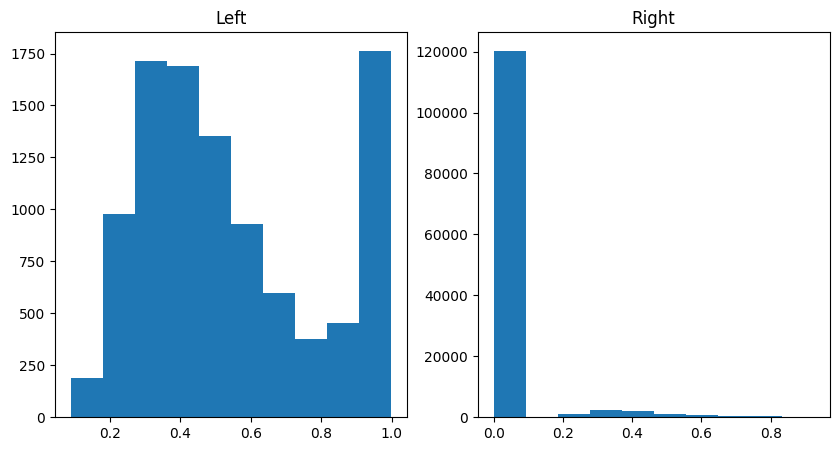

In [4]:
# load the two saved templates
template_28 = np.load('Path to EMG data/EMG/Processed/BBO28/BBO28_EMG_template.npy')

# Normalize the template before convolution
norm_template_28 = template_28.mean(axis = 0)
norm_template_28 /= np.linalg.norm(norm_template_28)

# Define your template and scaling factors
raw_data = raw_EMG.get_data(picks = 'emg')
template_length = len(norm_template_28)

matches = np.zeros((raw_data.shape[0], raw_data.shape[1]))
correlations = np.zeros((raw_data.shape[0], raw_data.shape[1]))
convolutions = np.zeros((raw_data.shape[0], raw_data.shape[1]))

for channel in range(raw_data.shape[0]):
    correlations[channel, :] = np.correlate(raw_data[channel, :], norm_template_28, mode='same')

corr_mean = np.zeros((raw_data.shape[0], raw_data.shape[1]))
corr_std = np.zeros((raw_data.shape[0], raw_data.shape[1]))
data_mean = np.zeros((raw_data.shape[0], raw_data.shape[1]))
data_std = np.zeros((raw_data.shape[0], raw_data.shape[1]))
All_peaks = []
for channel in range(raw_data.shape[0]):    
    window_size = 4000 
    corr_mean[channel, :] = np.convolve(correlations[channel, :], np.ones(window_size)/window_size, mode='same')
    corr_std[channel, :] = np.sqrt(np.convolve(correlations[channel, :]**2, np.ones(window_size)/window_size, mode='same') - corr_mean[channel, :]**2)
    
    threshold = corr_mean[channel, :] + corr_std[channel, :]
    peaks, _ = find_peaks(correlations[channel, :], height=threshold)
    All_peaks.append(peaks)


# Loop through all peaks to gather the correlations
All_correlations = {'left': np.zeros(len(All_peaks[0])), 'right': np.zeros(len(All_peaks[1]))}
for channel in range(raw_data.shape[0]):
    for idx, peak in enumerate(All_peaks[channel]):
        tempsegment = raw_data[channel,peak-(template_length//2):peak+(template_length//2)]
        if len(tempsegment) < template_length:
            continue
        correlation = np.corrcoef(tempsegment, norm_template_28)[0, 1]
        if channel == 0:
            All_correlations['left'][idx] = correlation
        else:
            All_correlations['right'][idx] = correlation
assert All_correlations['left'].shape[0] == len(All_peaks[0]), 'Correlation shape mismatch'
assert All_correlations['right'].shape[0] == len(All_peaks[1]), 'Correlation shape mismatch'


plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.hist(All_correlations['left'])
plt.title('Left')
plt.subplot(1,2,2)
plt.hist(All_correlations['right'])
plt.title('Right')
plt.show()

In [ ]:
# # Exploration for threshold
# minthresh = 0.8

# matches = np.where((All_correlations['left'] > minthresh) & (All_correlations['left'] < minthresh+.05))[0]
# matches.shape

# # pick a few random matches and inspect them
# random_matches = np.random.choice(matches, 16, replace=False)
# plt.figure(figsize = (10, 5))
# for i, match in enumerate(random_matches):
#     plt.subplot(4,4,i+1)
#     plt.plot(raw_data[0,All_peaks[0][match]-(template_length//2):All_peaks[0][match]+(template_length//2)])
# plt.show()

In [13]:

def find_correlation_peaks(raw_data,norm_template_28):
    """
    Finds peaks in the cross-correlation between a raw data signal and a template.

    Parameters:
    ----------
    raw_data : numpy.ndarray
        2D array of shape (channels, samples), containing the raw signals for multiple channels.
    template_28 : numpy.ndarray
        1D or 2D array representing the template to match against the raw data.

    Returns:
    -------
    All_peaks : list of numpy.ndarray
        A list where each element corresponds to the indices of detected peaks for a channel.
    """

    # Define your template and scaling factors
    correlations = np.zeros((raw_data.shape[0], raw_data.shape[1]))

    for channel in range(raw_data.shape[0]):
        correlations[channel, :] = np.correlate(raw_data[channel, :], norm_template_28, mode='same')

    corr_mean = np.zeros((raw_data.shape[0], raw_data.shape[1]))
    corr_std = np.zeros((raw_data.shape[0], raw_data.shape[1]))
    All_peaks = []
    for channel in range(raw_data.shape[0]):    
        window_size = 4000
        corr_mean[channel, :] = np.convolve(correlations[channel, :], np.ones(window_size)/window_size, mode='same')
        corr_std[channel, :] = np.sqrt(np.convolve(correlations[channel, :]**2, np.ones(window_size)/window_size, mode='same') - corr_mean[channel, :]**2)
        
        threshold = corr_mean[channel, :] + corr_std[channel, :]
        peaks, _ = find_peaks(correlations[channel, :], height=threshold)
        All_peaks.append(peaks)
    return All_peaks


def extract_correlations(raw_data,norm_template_28,All_peaks):
    # Loop through all peaks to gather the correlations
    All_correlations = {'left': np.zeros(len(All_peaks[0])), 'right': np.zeros(len(All_peaks[1]))}
    template_length = len(norm_template_28)
    for channel in range(raw_data.shape[0]):
        for idx, peak in enumerate(All_peaks[channel]):
            tempsegment = raw_data[channel,peak-(template_length//2):peak+(template_length//2)]
            if len(tempsegment) < template_length:
                continue
            correlation = np.corrcoef(tempsegment, norm_template_28)[0, 1]
            if channel == 0:
                All_correlations['left'][idx] = correlation
            else:
                All_correlations['right'][idx] = correlation
    assert All_correlations['left'].shape[0] == len(All_peaks[0]), 'Correlation shape mismatch'
    assert All_correlations['right'].shape[0] == len(All_peaks[1]), 'Correlation shape mismatch'
    return All_correlations


def correct_data_with_template(raw_data, norm_template_28, All_peaks, corrthresh=0.8):
    """
    Correct data segments based on a template match.

    Parameters:
        raw_data (np.ndarray): The raw data array (channels x samples).
        norm_template_28 (np.ndarray): The normalized template to match.
        All_peaks (list of lists): Indices of detected peaks for each channel.
        corrthresh (float): Threshold for correlation to consider a match.

    Returns:
        Corrected_data (np.ndarray): The corrected data.
        All_errors (dict): Squared error for left and right channels.
    """

    template_length = len(norm_template_28)
    Corrected_data = np.copy(raw_data)

    # Taper the edges of the template
    negative_ramp = [0, 50]
    positive_ramp = [150, template_length]
    ramp_up = np.hanning((negative_ramp[1] - negative_ramp[0]) * 2)[:(negative_ramp[1] - negative_ramp[0])]
    ramp_down = np.hanning((positive_ramp[1] - positive_ramp[0]) * 2)[(positive_ramp[1] - positive_ramp[0]):]
    tapered_template = np.copy(norm_template_28)
    print(tapered_template.shape)
    tapered_template[:negative_ramp[1]] *= ramp_up
    tapered_template[positive_ramp[0]:] *= ramp_down

    # Define the windows for scaling
    negative_win = [45, 80]
    positive_win = [115, 150]

    # Initialize error dictionary
    All_errors = {'left': np.zeros(len(All_peaks[0])), 'right': np.zeros(len(All_peaks[1]))}

    # Process each channel and peak
    for channel in range(Corrected_data.shape[0]):
        for idx, peak in enumerate(All_peaks[channel]):
            tempsegment = Corrected_data[channel, peak - (template_length // 2):peak + (template_length // 2)]
            if len(tempsegment) != template_length:
                continue

            # Check if it is a match
            correlation = np.corrcoef(tempsegment, norm_template_28)[0, 1]
            if correlation > corrthresh:
                scaling_window = [negative_win[0], positive_win[1]]
                slope, intercept, _, _, _ = linregress(
                    tapered_template[scaling_window[0]:scaling_window[1]],
                    tempsegment[scaling_window[0]:scaling_window[1]]
                )
                scaled_template = tapered_template * slope + intercept

                # Further scale each peak individually
                scaled_template[positive_win[0]:positive_win[1]] *= (
                    tempsegment[positive_win[0]:positive_win[1]].max() / scaled_template.max()
                )
                scaled_template[negative_win[0]:negative_win[1]] *= (
                    tempsegment[negative_win[0]:negative_win[1]].min() / scaled_template.min()
                )

                # Subtract the scaled template
                tempsegment = tempsegment - scaled_template

                # Calculate squared error
                error = np.sum((tempsegment - norm_template_28))
                if channel == 0:
                    All_errors['left'][idx] = error
                elif channel == 1:
                    All_errors['right'][idx] = error

                # Update the corrected data
                Corrected_data[channel, peak - (template_length // 2):peak + (template_length // 2)] = tempsegment

    return Corrected_data, All_errors



In [ ]:
raw_data = raw_EMG.get_data(picks = 'emg')
template_28 = np.load('Path to EMG data/EMG/Processed/BBO28/BBO28_EMG_template.npy')
# Normalize the template before convolution
norm_template_28 = template_28.mean(axis = 0)
norm_template_28 /= np.linalg.norm(norm_template_28)


All_peaks = find_correlation_peaks(raw_data,norm_template_28)
All_correlations = extract_correlations(raw_data, norm_template_28, All_peaks)
Corrected_data, All_errors = correct_data_with_template(
    raw_data=raw_data,
    norm_template_28=norm_template_28,
    All_peaks=All_peaks,
    corrthresh=0.9
)

(264,)


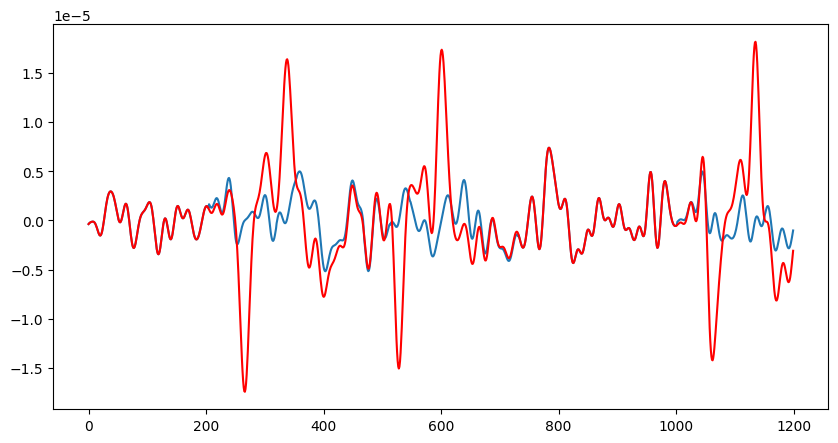

In [14]:
Corrected_data, All_errors = correct_data_with_template(
    raw_data=raw_data,
    norm_template_28=norm_template_28,
    All_peaks=All_peaks,
    corrthresh=0.9
)

peak_idx = 1000
plt.figure(figsize = (10, 5))
plt.plot(Corrected_data[0,All_peaks[0][peak_idx] - 600:All_peaks[0][peak_idx] + 600])
plt.plot(raw_data[0,All_peaks[0][peak_idx] - 600:All_peaks[0][peak_idx] + 600], 'r')
plt.show()

(264,)


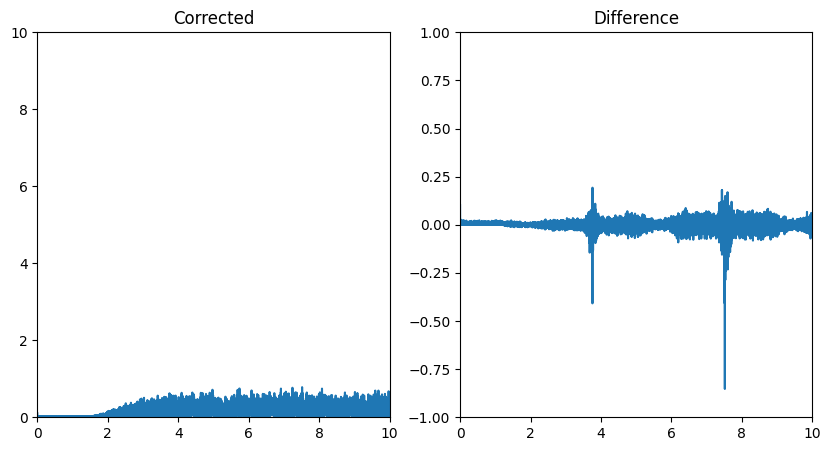

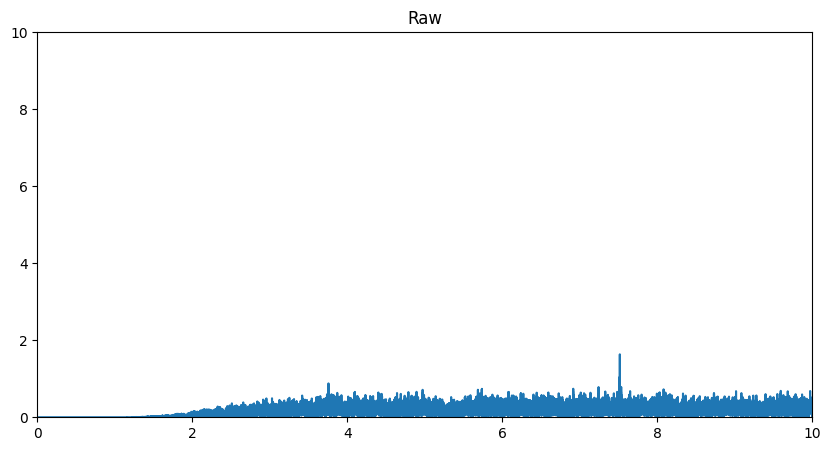

In [15]:
# Testing the impact of correlation thresholds - .9 seems to be optimal
corrthresh = 0.9
Corrected_data, All_errors = correct_data_with_template(
    raw_data=raw_data,
    norm_template_28=norm_template_28,
    All_peaks=All_peaks,
    corrthresh=corrthresh
)

# Compute fft of the corrected data and get frequencies using MNE functions
# Assuming Corrected_data is a 2D array (channels x time)
sampling_rate = 1000  # Replace with your actual sampling rate (Hz)
n_channels, n_samples = Corrected_data.shape

# Compute the FFT for each channel
fft_results = np.fft.fft(Corrected_data, axis=1)  # FFT along the time axis
frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)  # Corresponding frequencies

# Only keep the positive frequencies and real parts
positive_freq_indices = frequencies >= 0
data_fft = np.abs(fft_results[:, positive_freq_indices])
frequencies = frequencies[positive_freq_indices]

# Compute the FFT for each channel
fft_results = np.fft.fft(raw_data, axis=1)  # FFT along the time axis
frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)  # Corresponding frequencies

# Only keep the positive frequencies and real parts
positive_freq_indices = frequencies >= 0
rawdata_fft = np.abs(fft_results[:, positive_freq_indices])
frequencies = frequencies[positive_freq_indices]

# Difference between corrected and raw data
diff_fft = data_fft - rawdata_fft   

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.plot(frequencies, data_fft[0,:])
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Corrected')
plt.subplot(1,2,2)
plt.plot(frequencies, diff_fft[0,:])
plt.xlim(0, 10)
plt.ylim(-1, 1)
plt.title('Difference')
plt.show()

# plot the raw data fft
plt.figure(figsize = (10, 5))
plt.plot(frequencies, rawdata_fft[0,:])
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Raw')
plt.show()

In [ ]:
# For template extraction
# First load a dataset before running the code below
trial = 2

artifact_idx = np.where(emg_data[trial,0,:] > 1.5*1e-4)[0]
temp_vec = np.zeros(len(emg_data[trial,0,:]))
temp_vec[artifact_idx] = emg_data[trial,0,artifact_idx]

# find the index of the peaks in the temp_vec
peaks, _ = scipy.signal.find_peaks(temp_vec)
print(np.diff(peaks))

if trial == 0:
    template = []
    half_width = int(np.min(np.diff(peaks))/2)
print(half_width)

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.plot(emg_data[trial,0,:])
plt.plot(peaks, emg_data[trial,0,peaks], 'g*')
plt.title('Left EMG')
plt.subplot(1,2,2)
plt.plot(emg_data[trial,1,:])
plt.title('Right EMG')
plt.show()



In [ ]:
if 'template' not in locals():
    template = []
for peak in peaks:
    peak = int(peak)
    segment = emg_data[trial,0,peak-half_width:peak+half_width]
    if len(segment) == half_width*2:
        template.append(segment)
    print(len(template))

In [ ]:

template_np = []
for temp in range(len(template)):
    if len(template[temp]) == half_width*2:
        template_np.append(np.array(template[temp]))

template_np = np.array(template_np)

# save the template
np.save(os.path.join(subject_write_path, f'{participant}_EMG_template.npy'), template_np)
